Notes: IndoBERT + new preprocess (lowercase, expand repeated words, replace slang)

### Import Library

Class counts:
sarcasm
0    2200
1    2200
Name: count, dtype: int64


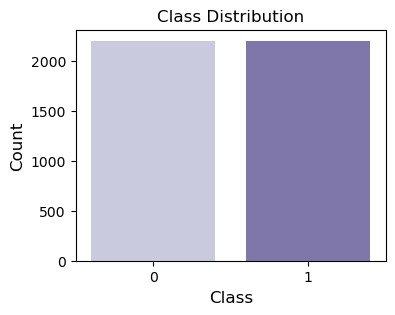

File saved as ./Dataset/dataset_sarkasme_new.xlsx


In [1]:
%run preprocess_dataset.ipynb

In [2]:
import re
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score
from indoNLP.preprocessing import replace_slang
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

c:\Users\ajeng\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### Load Dataset

In [3]:
df = pd.read_excel('./Dataset/dataset_sarkasme_new.xlsx')

In [4]:
df['preprocessed_text'][0]

'mungkin mereka lupa, presiden itu produk politik yang mengakar dari partai politik. kalau seorang presiden mendukung kader yang diusung partai politiknya, lalu salahnya dimana? this is how politics works!'

### Tokenizing

In [5]:
df['sarcasm'] = df['sarcasm'].astype(int)  # Ensure labels are integers

In [6]:
# Tokenizer Setup
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

In [7]:
# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=202):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(0),
            'attention_mask': encodings['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Data proportion 60%:20%:20%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['preprocessed_text'], df['sarcasm'], test_size=0.4, random_state=42, stratify=df['sarcasm']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [9]:
# Create datasets and data loaders
train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)
test_dataset = TextDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

### Training

In [10]:
# Load IndoBERT model
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2", num_labels=2
)

c:\Users\ajeng\anaconda3\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=

In [11]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=3e-6)

c:\Users\ajeng\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Training Function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        # Collect predictions and true labels for accuracy calculation
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    # Calculate train accuracy
    accuracy = accuracy_score(true_labels, predictions)

    return total_loss / len(data_loader), accuracy

In [14]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []
    total_loss = 0  # Track total test loss
    criterion = torch.nn.CrossEntropyLoss()  # Define the loss function

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = criterion(outputs.logits, labels)  # Compute loss
            total_loss += loss.item()  # Accumulate loss

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate average test loss
    avg_loss = total_loss / len(data_loader)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Generate classification report
    class_report = classification_report(true_labels, predictions, digits=4)

    return predictions, true_labels, accuracy, avg_loss, class_report

In [15]:
epochs = 1
total_start_time = time.time()  # Start timing before training begins

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{epochs}")

    # Training Phase
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}")

    # Evaluation Phase
    print("Evaluating on validation set...")
    predictions, true_labels, test_accuracy, test_loss, class_report = evaluate(model, val_loader, device)
    print(f"Validation Loss = {test_loss:.4f}, Validation Accuracy = {test_accuracy:.4f}")

    # Testing Phase
    print("Evaluating on test set...")
    predictions, true_labels, test_accuracy, test_loss, class_report = evaluate(model, test_loader, device)
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

    # Track time for this epoch
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} seconds.\n")

Epoch 1/1
Train Loss = 0.4993, Train Accuracy = 0.7542
Evaluating on validation set...
Validation Loss = 0.3541, Validation Accuracy = 0.8364
Evaluating on test set...
Test Loss = 0.3906, Test Accuracy = 0.8227
Epoch 1 completed in 2262.82 seconds.



In [16]:
# Total training time
total_elapsed_time = time.time() - total_start_time
print(f"Total training time: {total_elapsed_time:.2f} seconds.")

Total training time: 2262.92 seconds.


### Save Model

In [176]:
# Save last trained model
torch.save(model.state_dict(), "./Trained_Model/trained_model_IndoBERT.pth")\
    
print("Last trained model saved.")
print("Training complete.")

Last trained model saved.
Training complete.


### Load Model

In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [178]:
# Load the best model's weights
model.load_state_dict(torch.load("./Trained_Model/trained_model_IndoBERT.pth"))
model.to(device)

C:\Users\ajeng\AppData\Local\Temp\ipykernel_13748\433788419.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./Trained_Model/trained_mod

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Visualization Result

In [180]:
# Evaluate the best model and get predictions and true labels
predictions, true_labels, model_accuracy, model_loss, class_report = evaluate(model, test_loader, device)

print(f"Model Test Loss = {model_loss:.4f}, Test Accuracy = {model_accuracy:.4f}")

Model Test Loss = 0.3909, Test Accuracy = 0.8261


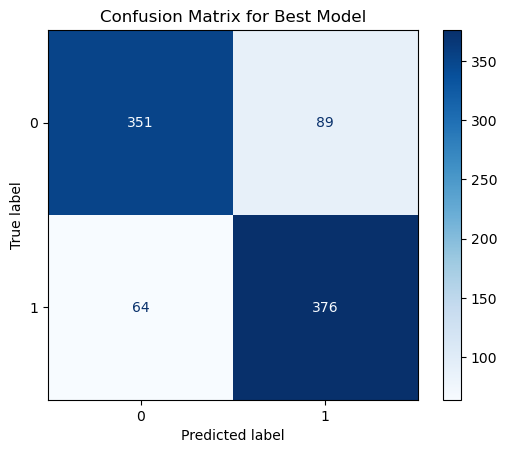

In [182]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.show()

In [184]:
# Classification Report Test

# Evaluate the trained model
predictions, true_labels, accuracy, avg_loss, class_report = evaluate(model, test_loader, device)

# Display the results
print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

Test Loss: 0.3909
Test Accuracy: 0.8261

Classification Report:
              precision    recall  f1-score   support

           0     0.8458    0.7977    0.8211       440
           1     0.8086    0.8545    0.8309       440

    accuracy                         0.8261       880
   macro avg     0.8272    0.8261    0.8260       880
weighted avg     0.8272    0.8261    0.8260       880



### Test Model

In [185]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Initialize the same model architecture
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2) 

c:\Users\ajeng\anaconda3\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=

In [ ]:
# Load trained weights
model.load_state_dict(torch.load("./Trained_Model/trained_model_IndoBERT.pth"))
model.eval()  # Set model to evaluation mode

In [187]:
# Example input
text = "yeah"

In [188]:
# Preprocessing

text = lower_text(text)
text = expand_repeated_words(text)
text = replace_slang(text)

text

'yeah'

In [189]:
# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [190]:
# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Predicted class: {predicted_class}")

Predicted class: 0
